# HAND Detection test

Test implementation for HAND detection algorithm. This method was used as a tool to select windows of the signal without events but with relevant behavior

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [38]:
def exp_std(x):
    GAMMA = 0.0001
    
    n_windows = 4
    samples_per_cycle = 256
    window_size = samples_per_cycle * n_windows

    x = np.reshape(x, (x.shape[0],))

    max_index_list, max_list = [], []
    for i in range(0, x.shape[0], samples_per_cycle):
        max_index = i + np.argmax(abs(x[i : i + samples_per_cycle])) # We add i so the max_index refers to the x and not just the cut [i : i + samples]
        max_index_list.append(max_index)
        max_list.append(abs(x[max_index]))

    x_interp = np.interp(np.arange(x.shape[0]), max_index_list, max_list)

    vetor_mean = np.zeros_like(x_interp)
    vetor_std = np.zeros_like(x_interp)
    for i in range(0, x_interp.shape[0] - window_size, window_size):
        vetor_mean[i : i + window_size] = np.mean(x_interp[i : i + window_size])
        # vetor_std[i : i + window_size] = np.std(x_interp[i : i + window_size])

    for i in range(window_size, x_interp.shape[0] - window_size, window_size):
        for j in range(0, window_size):
            vetor_mean[i + j] = vetor_mean[i + j - 1] + (x_interp[i + j] -  x_interp[i + j - window_size]) / float(window_size)
            vetor_std[i + j] = vetor_std[i + j - 1] + ((x_interp[i + j] ** 2 - x_interp[i + j - window_size] ** 2) / (float(window_size) - 1)) + \
                                ((float(window_size) / (float(window_size) - 1)) * (vetor_mean[i + j - 1] ** 2 - vetor_mean[i + j] ** 2))

    vetor_std = vetor_std / np.max(vetor_std) # Scale

    detec_signal = np.where(vetor_std > GAMMA, 1, 0)
    detec_signal = np.diff(detec_signal)

    events = np.argwhere(detec_signal == 1)

    return events, vetor_std

In [19]:
arq = h5py.File("../Synthetic_Full_iHall.hdf5", "r")

load_qtd = "1"

rawSamples = arq[load_qtd]["i"]
rawEvents = arq[load_qtd]["events"]    
rawLabels = arq[load_qtd]["labels"]

In [ ]:
x = rawSamples[10]

events = exp_std(x)

plt.figure(figsize=(25, 10))
plt.plot(x)

events_array = np.zeros_like(x)
events_array[events] = np.max(x)
plt.plot(events_array)

plt.show()

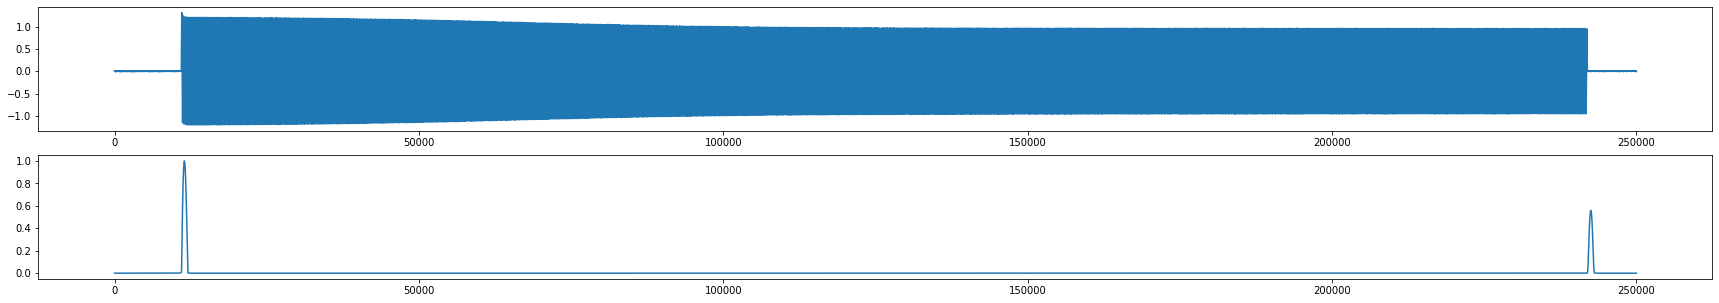

In [39]:
x = rawSamples[2 * 16]

events, vetor_std = exp_std(x)

f, (ax1, ax2) = plt.subplots(2, 1, sharey=False)
ax1.plot(x[20000:270000])

ax2.plot(vetor_std[20000:270000])

plt.show()